# RGI02 (Western Canada and USA)

F. Maussion

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [2]:
# Region of interest 
reg = 2

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '02_rgi60_WesternCanadaUS.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, df_classes = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
616,42,1.2,"Fountain, Hoffman",Hoffman,2016,Conterminous USA,2001,2001,2001
617,36,1.4,"Fountain, Hoffman",Hoffman,2016,Conterminous USA,1999,1999,1999
618,39,1.4,"Fountain, Hoffman",Hoffman,2016,Conterminous USA,1990,1990,1990
619,5,0.2,"Fountain, Hoffman",Hoffman,2016,Conterminous USA,1958,1958,1958
623,12464,13054.8,Bolch,Bolch,2009,Northern Cordillera,2006,2004,2006
624,1,0.4,"Beedle, Berthier, Bolch, Burgess, Cogley, Fors...",Cogley,2015,Randolph Glacier Inventory; Umbrella RC for me...,2004,2004,2004
635,1235,656.5,"Berthier, Bolch, Cogley, Kienholz",Cogley,2015,Randolph Glacier Inventory; Umbrella RC for me...,1985,1968,1999
647,1002,25.8,"Mozer, Pflug",Mozer,2017,Olympic Peninsula,2015,2015,2015
721,1,136.9,Bolch,Bolch,2009,Northern Cordillera,2006,2006,2006


Notes based on inidivual submission evaluations: 
- 635 is for all glaciers above 60°N (was used in RGI6)
- 624 is a lonely glacier on the close to Region 01 border, it was misplaced in RGI6 and is already available in 623!
- 623 is for the rest of the glaciers in Canada not covered by 635. The version in GLIMS has several issues ([GH issue](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/8))
- 619: not clear what this is. the 5 outlines are already available in 614
- 618: an intermediate inventory for the colorado range
- 617: a further intermediate inventory for the colorado range
- 616: used by RGI for Colorado to replace 614 in this region (make a shape to select them)
- 744: all the rest of USA
- 721, 722: update of two outlines by Bruce which we need to use

In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

Remove the useless inventories now:

In [7]:
shp = shp.loc[shp['subm_id'].isin([744, 616, 623, 635, 721, 722])].copy()

### Read in the geometry data for sub-inventory selection 

In [8]:
# Read L2 files
shp_loc = gpd.read_file('tar://' + support_dir + f'/sub_inventory_sel_RGI02.tar.gz/sub_inventory_sel_RGI02.shp')

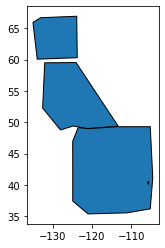

In [9]:
shp_loc.plot(edgecolor='k');

In [10]:
shp_loc

,id,subm_id,geometry
0,0,616,"POLYGON ((-105.68419 40.55319, -105.61947 40.5..."
1,1,623,"POLYGON ((-121.23794 49.00086, -124.76653 49.4..."
2,2,635,"POLYGON ((-135.01855 65.94399, -133.07648 66.6..."
3,3,744,"POLYGON ((-123.51553 49.16964, -121.23777 49.0..."


In [11]:
# Test the polygons I drew - each subregion should be equivalent as the sel by id
for sub_id in [635, 623, 616]:
    sel = shp.loc[shp['subm_id'] == sub_id].copy()
    rp = sel.representative_point().to_frame('geometry')
    rp['orig_index'] = sel.index
    intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == sub_id], how='intersection')
    odf = sel.loc[intersect['orig_index']]
    assert len(sel) == len(odf)
    
# Also even without preselection
rp = shp.representative_point().to_frame('geometry')
rp['orig_index'] = shp.index
for sub_id in [635, 623]:
    sel = shp.loc[shp['subm_id'] == sub_id].copy()
    intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == sub_id], how='intersection')
    odf = shp.loc[intersect['orig_index']]
    delta = 0
    if sub_id == 623:
        delta = 2  # Those two glaciers
    assert len(sel) + delta == len(odf)   
    
# for 614, 616 we mix and mingle but I trust what we have done below

### Apply selection criteria to create the RGI7 data subset

In [12]:
# for northern Canada we use 'subm_id' 635 by analyst 'Berthier, Etienne'
RGI_ss_NCan = shp.loc[shp['subm_id'] == 635].copy()
needs_size_filter(RGI_ss_NCan)

False

In [13]:
# for southern Canada we use 'subm_id' 623 by analyst 'Bolch, Tobias' (with 721, 722 which are corrections)
RGI_ss_SCan = shp.loc[shp['subm_id'].isin([623, 721, 722])].copy()
print(len(RGI_ss_SCan))
RGI_ss_SCan = size_filter(RGI_ss_SCan)
len(RGI_ss_SCan)

12466


12465

In [14]:
# For CONUS we use 'subm_id' 744 by analyst 'Fountain, Andrew G.' except for colorado
RGI_ss_CONUS = shp.loc[shp['subm_id'] == 744].copy()

# Remove colorado
print(len(RGI_ss_CONUS))
rp = RGI_ss_CONUS.representative_point().to_frame('geometry')
rp['orig_index'] = RGI_ss_CONUS.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 744], how='intersection')
RGI_ss_CONUS = RGI_ss_CONUS.loc[intersect['orig_index'].values].copy()
print(len(RGI_ss_CONUS))
RGI_ss_CONUS = size_filter(RGI_ss_CONUS)
len(RGI_ss_CONUS)

5166
5133


5126

In [15]:
# For Colorado we use 'subm_id' 616 by analyst 'Fountain, Andrew G.' 
RGI_ss_Colo = shp.loc[shp['subm_id'] == 616].copy()
print(len(RGI_ss_Colo))
RGI_ss_Colo = size_filter(RGI_ss_Colo)
len(RGI_ss_Colo)

42


33

In [16]:
# combine the geodataframes
rgi7 = pd.concat([RGI_ss_NCan, RGI_ss_SCan, RGI_ss_CONUS, RGI_ss_Colo])

### Some sanity checks 

In [17]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
635,1235,1235
623,12463,12463
721,1,1
722,1,1
744,5126,5126
616,33,33


In [18]:
# Nothing should change here
rgi7['is_rgi6'] = True

In [19]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

Orphan rock outcrops detected in subm_id [623.]


In [20]:
orphan_f = orphan_f.loc[orphan_f.subm_id == 623]
orphan_f['area'].sum() * 1e-6

0.12101501682015459

Ok, more details in the checks below.

### Plots 

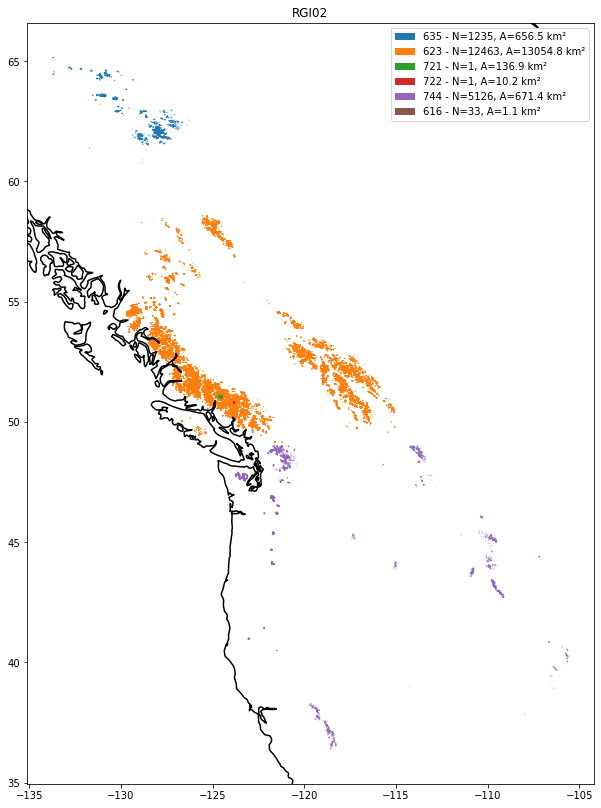

In [21]:
plot_map(rgi7, reg)

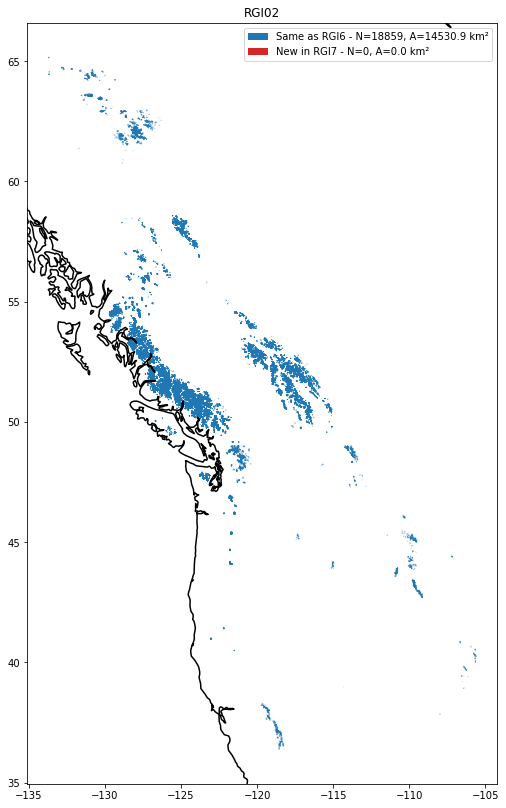

In [22]:
plot_map(rgi7, reg, is_rgi6=True)

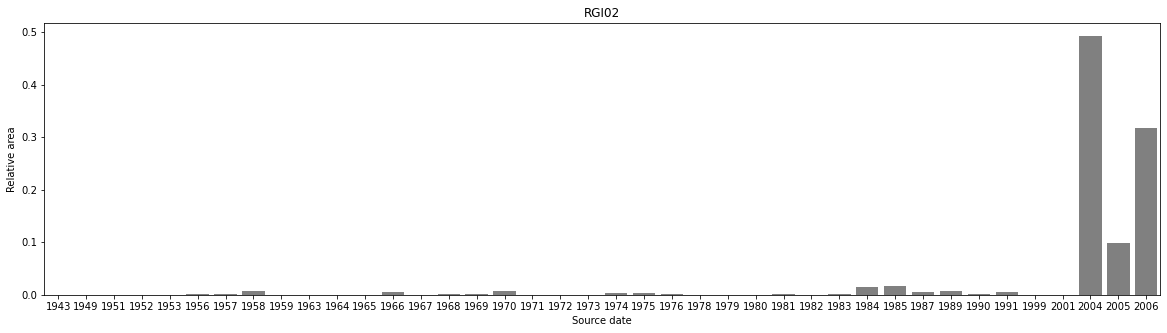

In [23]:
plot_date_hist(rgi7, reg=reg, figsize=(20, 5))

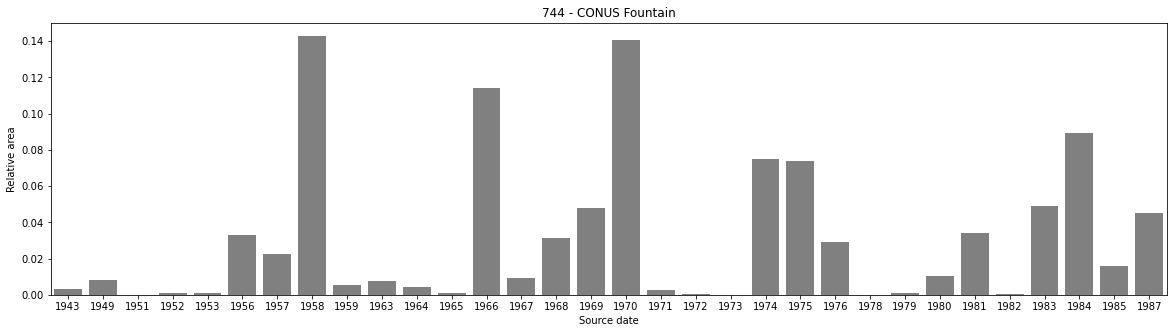

In [24]:
plot_date_hist(RGI_ss_CONUS, title='744 - CONUS Fountain', figsize=(20, 5), savefig=False)

### Text for github

In [27]:
fgh = sdf.T
fgh

subm_id,635,623,721,722,744,616
N,1235,12463,1,1,5126,33
A,656.5,13054.8,136.9,10.2,671.4,1.1
analysts,"Berthier, Bolch, Cogley, Kienholz",Bolch,Bolch,Bolch,Fountain,"Fountain, Hoffman"
submitters,Cogley,Bolch,Bolch,Bolch,Fountain,Hoffman
release_date,2015,2009,2009,2009,2016,2016
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Northern Cordillera,Northern Cordillera,Northern Cordillera,Conterminous USA,Conterminous USA
src_date_mode,1985,2006,2006,2006,1966,2001
src_date_min,1968,2004,2006,2006,1943,2001
src_date_max,1999,2006,2006,2006,1987,2001


In [28]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 635                                                                    | 623                 | 721                 | 722                 | 744              | 616               |
|:--------------|:-----------------------------------------------------------------------|:--------------------|:--------------------|:--------------------|:-----------------|:------------------|
| N             | 1235                                                                   | 12463               | 1                   | 1                   | 5126             | 33                |
| A             | 656.5                                                                  | 13054.8             | 136.9               | 10.2                | 671.4            | 1.1               |
| analysts      | Berthier, Bolch, Cogley, Kienholz                                      | Bolch               | Bolch               | Bolch               | Fountain         | Fountain, Hoffman |
| submitters    | Co

## Write out and tar 

In [29]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI02.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI02'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [30]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

## Compare new RGI7-file to RGI6

### Number of elements (differences depict problems)

In [31]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

Number of glaciers in new RGI: 18859
Number of glaciers in RGI6: 18855
Difference: 4


### How many nominal glaciers were there in RGI06?

In [32]:
len(ref_odf.loc[ref_odf.Status == 2])

0

### Total area

In [33]:
# add an area field to RGI_ss and reference data
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [34]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 14530.886140315337
Area RGI6 [km²]: 14524.240019596462
Area difference [km²]: 6.646120718874954


### Northern Canada (635, Berthier, no problem there):  

In [35]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 635], how='intersection')
ref_odf_NCan = ref_odf.loc[intersect['orig_index']].copy()

In [36]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_NCan))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_NCan))
print('Difference:', len(RGI_ss_NCan)-len(ref_odf_NCan))

Number of glaciers in RGI7 subset: 1235
Number of glaciers in reference data (RGI6): 1235
Difference: 0


In [37]:
# print and compare area values
Area_7 = RGI_ss_NCan['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_NCan['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 656.5317836977715
Area RGI6 [km²]: 656.5319107844741
Area difference [km²]: -0.0001270867026050837


This is brilliant! No issue there.

### Southern Canada (623, Bolch, some problems):  

In [38]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 623], how='intersection')
ref_odf_SCan = ref_odf.loc[intersect['orig_index']].copy()

In [39]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_SCan))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_SCan))
print('Difference:', len(RGI_ss_SCan)-len(ref_odf_SCan))

Number of glaciers in RGI7 subset: 12465
Number of glaciers in reference data (RGI6): 12464
Difference: 1


In [40]:
# print and compare area values
Area_7 = RGI_ss_SCan['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_SCan['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 13201.819607709593
Area RGI6 [km²]: 13195.162964834108
Area difference [km²]: 6.656642875484977


We have one more glacier in GLIMS (this is expected from the glacier that was on the wrong side of the region border in RGI6)

In [41]:
RGI_ss_SCan.loc[RGI_ss_SCan.anlys_id == 380747]['area'].sum() * 1e-6 

0.42227292934575933

Arg, we still have 6 km2 more in GLIMS than RGI6. Quick check on GIS reveals that some polygons in polygons are in GLIMS but not RGI, and some rock outcrops are in RGI but not GLIMS (see [example](https://github.com/GLIMS-RGI/glims_issue_tracker/issues/8#issuecomment-981134080) in GH issue). We'll ignore this for now.

Also, orphaned rock outcrops:

In [53]:
# for i in range(len(orphan_f)):
#     f, ax = plt.subplots(figsize=(2, 2))
#     orphan_f.iloc[[i]].plot(ax=ax);

### CONUS (744, Fountain, OK):  

In [47]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 744], how='intersection')
ref_odf_CONUS = ref_odf.loc[intersect['orig_index']].copy()

In [48]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_CONUS))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_CONUS))
print('Difference:', len(RGI_ss_CONUS)-len(ref_odf_CONUS))

Number of glaciers in RGI7 subset: 5126
Number of glaciers in reference data (RGI6): 5123
Difference: 3


In [49]:
# print and compare area values
Area_7 = RGI_ss_CONUS['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_CONUS['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 671.4228538861278
Area RGI6 [km²]: 671.433249726907
Area difference [km²]: -0.01039584077921063


I don't know about the N glacier difference (not a big deal), and the missing area is small enough!

### Colorado (616, Fountain, OK):  

In [50]:
rp = ref_odf.representative_point().to_frame('geometry')
rp['orig_index'] = ref_odf.index
intersect = gpd.overlay(rp, shp_loc.loc[shp_loc['subm_id'] == 616], how='intersection')
ref_odf_Colo = ref_odf.loc[intersect['orig_index']].copy()

In [51]:
print('Number of glaciers in RGI7 subset:', len(RGI_ss_Colo))
print('Number of glaciers in reference data (RGI6):', len(ref_odf_Colo))
print('Difference:', len(RGI_ss_Colo)-len(ref_odf_Colo))

Number of glaciers in RGI7 subset: 33
Number of glaciers in reference data (RGI6): 33
Difference: 0


In [52]:
# print and compare area values
Area_7 = RGI_ss_Colo['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_7)
Area_6 = ref_odf_Colo['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_6)
d = (Area_7 - Area_6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 1.111895021844131
Area RGI6 [km²]: 1.111894250971996
Area difference [km²]: 7.708721350141445e-07
